In [1]:
from __future__ import print_function
import os
os.chdir(os.path.dirname(os.getcwd()))

## init stereo aruco detector scene builder

In [2]:
from pkg.marker_config import *
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.camera.realsense import RealSense
from pkg.detector.camera.kinect import Kinect
from pkg.geometry.builder.scene_builder import SceneBuilder

aruco_map = get_aruco_map()
stereo = ArucoStereo(aruco_map, [Kinect(), RealSense()])
stereo.initialize()
# stereo.calibrate()
s_builder = SceneBuilder(stereo, base_link="base_link")
# s_builder.reset_reference_coord(ref_name="floor")

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.


Start streaming


## collect reaching data

In [4]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.planning.scene import PlanningScene
from pkg.planning.constraint.constraint_actor import Gripper2Tool
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
import random

##
# @brief convert cylindrical coordinate to cartesian coordinate
# @param radius x-y plane radius 
# @param theta angle from x-axis, along z-axis
# @param height height from x-y plane
def cyl2cart(radius, theta, height):
    return np.cos(theta)*radius, np.sin(theta)*radius, height

##
# @brief convert cylindrical coordinate to cartesian coordinate
# @param theta position vector angle from x-axis, along z-axis
# @param azimuth_loc angle from radial axis along z axis
# @param zenith angle from bottom zenith
def hori2mat(theta, azimuth_loc, zenith):
    return Rot_axis_series([3,2], [theta+azimuth_loc, np.pi-zenith])

##
# @brief sample reaching plan results
def sample_reaching(mplan, robot_name, tool_link, home_pose, base_link="base_link", timeout=0.1,
                    radius_min=0.2, radius_max=1.3, theta_min=-np.pi, theta_max=np.pi,
                    height_min=-0.7, height_max=1.5, zenith_min=0, zenith_max=np.pi,
                    azimuth_min=-np.pi, azimuth_max=np.pi):
    radius = random.uniform(radius_min, radius_max)
    theta = random.uniform(theta_min, theta_max)
    height = random.uniform(height_min, height_max)
    azimuth_loc = random.uniform(azimuth_min, azimuth_max)
    zenith = random.uniform(zenith_min, zenith_max)

    xyz = cyl2cart(radius, theta, height)
    quat = tuple(Rotation.from_dcm(hori2mat(theta, azimuth_loc, zenith)).as_quat())
    goal_pose = xyz+quat
    trajectory, success = mplan.planner.plan_py(
        robot_name, tool_link, goal_pose, base_link, tuple(home_pose), timeout=timeout)
    return (radius, theta, height, azimuth_loc, zenith), success, trajectory

def collect_reaching_data(s_builder, robot_type, TIP_LINK, N_s):
    # set robot
    crob = CombinedRobot(robots_on_scene=[
        RobotConfig(0, robot_type, None,"")], connection_list=[False])
    ROBOT_NAME = crob.robot_names[0]
    xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
    crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)

    # create scene
    gscene = s_builder.create_gscene(crob, start_rviz=False)
    pscene = PlanningScene(gscene, combined_robot=crob)

    # make dummy binders
    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TIP_LINK, 
                       dims=(0.01,)*3, center=(0,0,0.0), rpy=(-np.pi/2,0,0), color=(1,0,0,1), display=True, collision=False, fixed=True)
    pscene.create_binder(bname="grip0", gname="grip0", rname=ROBOT_NAME, _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))

    mplan = MoveitPlanner(pscene)
    mplan.update_gscene()

    gtimer = GlobalTimer.instance()
    gtimer.reset()
    gtimer.tic("full_loop")
    featurevec_list = []
    success_list = []
    for i_s in range(N_s):
        featurevec, success, trajectory = sample_reaching(mplan, "indy0", "indy0_tcp", home_pose=crob.home_pose)
        xyz = cyl2cart(*featurevec[:3])
        orientation_mat = hori2mat(featurevec[1], *featurevec[-2:])
#         gscene.add_highlight_axis("hl", "toolvec", "base_link", xyz, orientation_mat)
        featurevec_list.append(featurevec)
        success_list.append(success)
        if i_s % 100 == 0 :
            t_cur = gtimer.toc("full_loop")
            print("{} / {} ({} / {} s): current success ratio = {}".format(
                i_s, N_s, int(t_cur/1000), int(float(N_s)/float(i_s+1e-3)*t_cur/1000), np.mean(success_list)))
            
    return featurevec_list, success_list

In [5]:
featurevec_list_test, success_list_test = collect_reaching_data(s_builder, RobotType.indy7, "indy0_tcp", 10000)
feature_mat_test = np.array(featurevec_list_test)

connection_list
[False]


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


0 / 300 (0 / 39652 s): current success ratio = 0.0
100 / 300 (10 / 30 s): current success ratio = 0.287128712871
200 / 300 (19 / 29 s): current success ratio = 0.298507462687


In [6]:
featurevec_list_train, success_list_train = collect_reaching_data(s_builder, RobotType.indy7, "indy0_tcp", 1000)
feature_mat_train = np.array(featurevec_list_train)

connection_list
[False]


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


0 / 300 (0 / 7995 s): current success ratio = 1.0
100 / 300 (9 / 28 s): current success ratio = 0.346534653465
200 / 300 (18 / 27 s): current success ratio = 0.358208955224


## Train and test

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

In [32]:
clf = svm.SVC(kernel='rbf', C=10)
clf.fit(feature_mat_train, success_list_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [33]:
np.mean(np.equal(clf.predict(feature_mat_train),success_list_train))

0.9733333333333334

In [34]:
np.mean(np.equal(clf.predict(feature_mat_test),success_list_test))

0.8666666666666667

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=40, centers=2, random_state=20)

In [9]:
clf = svm.SVC(kernel='rbf')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [10]:
newData = [[3,4]]
print(clf.predict(newData))

[0]


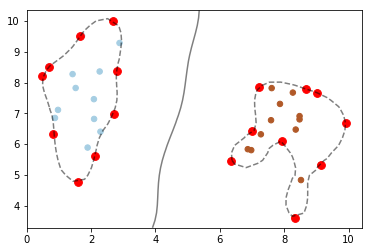

In [11]:
# 샘플 데이터 표현
plt.scatter(X[:,0], X[:,1], c=y, s=30, cmap=plt.cm.Paired)
# 초평면(Hyper-Plane) 표현
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1,0,1], alpha=0.5, linestyles=['--', '-', '--'])
# 지지벡터(Support Vector) 표현
ax.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=60, facecolors='r')
plt.show()

## Disconnect stereo

In [ ]:
stereo.disconnnect()